In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

import datetime
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import matplotlib.pyplot as plt
import statistics

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

from math import floor
from heapq import nlargest

from tqdm.notebook import tqdm, trange

from surprise import Dataset, Reader, SVD, accuracy, dump
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split

import locale

locale.setlocale(locale.LC_ALL, 'fr_FR')
import pickle

# Import des modules contenant les fonctions utilitaires

In [2]:
# Réglage des graphiques

plt.style.use('seaborn-whitegrid')

plt.rc('font', size=14)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=14)

dims_fig = (10,6)

C:\Users\benab\AppData\Local\Temp\ipykernel_10228\1773293885.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [3]:
clicks_sample = pd.read_csv("data/clicks_sample.csv")
articles_metadata = pd.read_csv("data/articles_metadata.csv")
all_csv_files = glob.glob(os.path.join("data/clicks/", "*.csv"))
clicks_data = pd.concat((pd.read_csv(f) for f in all_csv_files),
                        ignore_index=True)
clicks_data.to_csv("data/clicks_data.csv", index=False)

In [4]:
clicks_sample

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1878,705,1506828968165442,1506828968000,2,119592,1506830912301,4,1,17,1,21,2
1879,705,1506828968165442,1506828968000,2,284847,1506830942301,4,1,17,1,21,2
1880,706,1506828979881443,1506828979000,3,108854,1506829027334,4,3,2,1,25,1
1881,706,1506828979881443,1506828979000,3,96663,1506829095732,4,3,2,1,25,1


In [5]:
clicks_data

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2988176,10051,1508211372158328,1508211372000,2,84911,1508211557302,4,3,2,1,25,1
2988177,322896,1508211376302329,1508211376000,2,30760,1508211672520,4,1,17,1,25,2
2988178,322896,1508211376302329,1508211376000,2,157507,1508211702520,4,1,17,1,25,2
2988179,123718,1508211379189330,1508211379000,2,234481,1508211513583,4,3,2,1,25,2


In [6]:
articles_metadata

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162
...,...,...,...,...,...
364042,364042,460,1434034118000,0,144
364043,364043,460,1434148472000,0,463
364044,364044,460,1457974279000,0,177
364045,364045,460,1515964737000,0,126


In [7]:
print("Nombre d'utilisateurs unique   :", clicks_data["user_id"].nunique())
print("Nombre de clics enregistré     :", len(clicks_data))
print("Nombre d'articles              :", len(articles_metadata))
print("Nombre de catégories d'article :",
      articles_metadata["category_id"].nunique())

Nombre d'utilisateurs unique   : 322897
Nombre de clics enregistré     : 2988181
Nombre d'articles              : 364047
Nombre de catégories d'article : 461


In [8]:
articles_metadata.describe()

,article_id,category_id,created_at_ts,publisher_id,words_count
count,364047.000000,364047.000000,3.640470e+05,364047.0,364047.000000
mean,182023.000000,283.108239,1.474070e+12,0.0,190.897727
std,105091.461061,136.723470,4.293038e+10,0.0,59.502766
min,0.000000,0.000000,1.159356e+12,0.0,0.000000
25%,91011.500000,199.000000,1.444925e+12,0.0,159.000000
50%,182023.000000,301.000000,1.489422e+12,0.0,186.000000
75%,273034.500000,399.000000,1.509891e+12,0.0,218.000000
max,364046.000000,460.000000,1.520943e+12,0.0,6690.000000


In [9]:
articles_metadata.isna().mean()

article_id       0.0
category_id      0.0
created_at_ts    0.0
publisher_id     0.0
words_count      0.0
dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

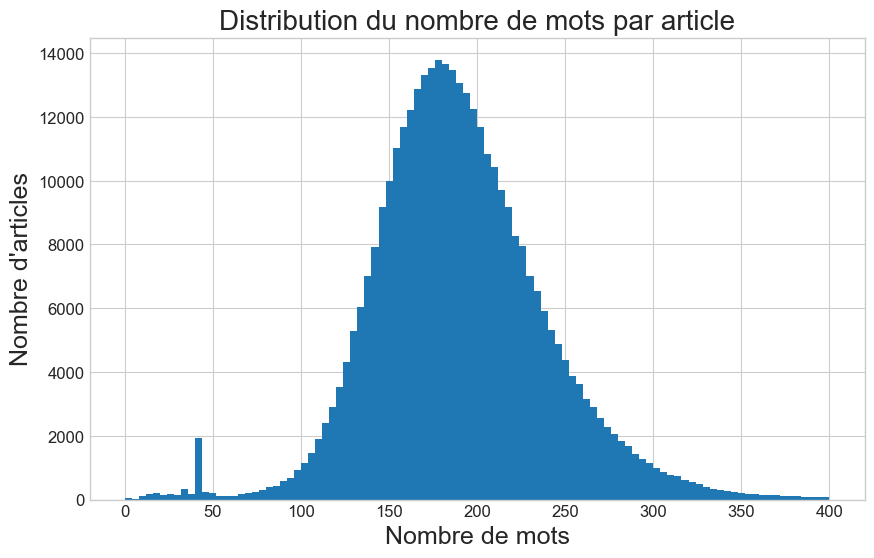

In [10]:
articles_metadata['words_count'].hist(figsize=dims_fig, bins=100, range=(0,400))
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre d'articles")
plt.title("Distribution du nombre de mots par article")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

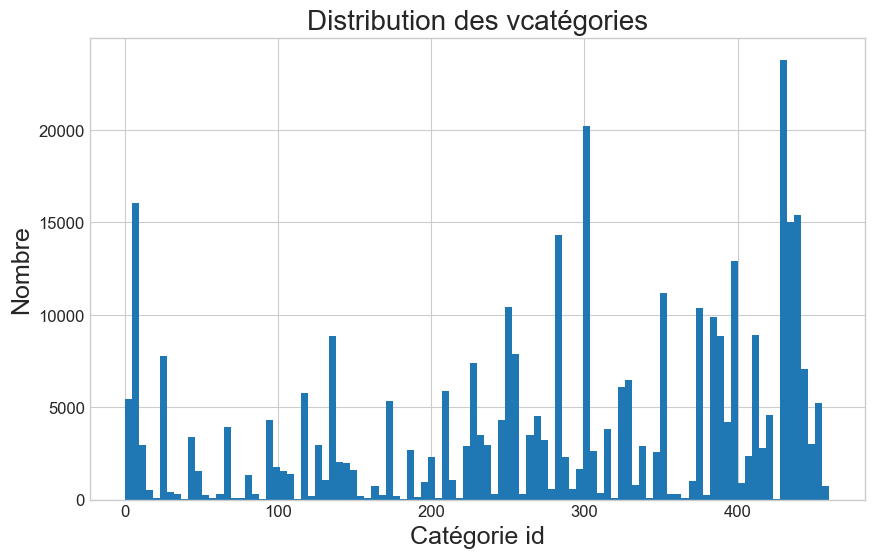

In [11]:
articles_metadata['category_id'].hist(figsize=dims_fig, bins=100)
plt.xlabel("Catégorie id")
plt.ylabel("Nombre")
plt.title("Distribution des vcatégories")
plt.show

clicks 

In [12]:
clicks_sample

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1878,705,1506828968165442,1506828968000,2,119592,1506830912301,4,1,17,1,21,2
1879,705,1506828968165442,1506828968000,2,284847,1506830942301,4,1,17,1,21,2
1880,706,1506828979881443,1506828979000,3,108854,1506829027334,4,3,2,1,25,1
1881,706,1506828979881443,1506828979000,3,96663,1506829095732,4,3,2,1,25,1


On ne va ici s'intéresser qu'aux colonnes suivantes :

user_id : id du user
session_size : nombre de clicks du user durant la session
click_article_id : article lu durant la session
Ce fichier n'est qu'un échantillon, il faut regarder les fichiers du dossier click.csv pour récupérer l'ensemble des sessions des utilisateurs.

In [13]:
clicks_data

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2988176,10051,1508211372158328,1508211372000,2,84911,1508211557302,4,3,2,1,25,1
2988177,322896,1508211376302329,1508211376000,2,30760,1508211672520,4,1,17,1,25,2
2988178,322896,1508211376302329,1508211376000,2,157507,1508211702520,4,1,17,1,25,2
2988179,123718,1508211379189330,1508211379000,2,234481,1508211513583,4,3,2,1,25,2


In [14]:
clicks_data.describe()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181,2988181
unique,322897,1048594,646874,72,46033,2983198,3,5,8,11,28,7
top,5890,1507563657895091,1507563657000,2,160974,1506961009961,4,1,17,1,25,2
freq,1232,124,127,1260372,37213,3,2904478,1823162,1738138,2852406,804985,1602601


In [15]:
clicks_data = clicks_data[['user_id','session_id','session_size', 'click_article_id']]
print(clicks_data.shape)
clicks_data.head()

(2988181, 4)


,user_id,session_id,session_size,click_article_id
0,0,1506825423271737,2,157541
1,0,1506825423271737,2,68866
2,1,1506825426267738,2,235840
3,1,1506825426267738,2,96663
4,2,1506825435299739,2,119592


articles_embeddings.pickle

In [16]:
articles_emb = pd.read_pickle("data/articles_embeddings.pickle")

In [17]:
articles_emb = pd.DataFrame(articles_emb,
                            columns=
                            ["embedding_" + str(i) for i in range(
                                articles_emb.shape[1])])
articles_emb.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,...,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


Modélisation

Le fichier articles_embedding sera uploadé sur Azure Blob Storage afin d'être utilisé par ma fonction Azure Function. Le fichier fait actuellement 355Mo, il est trop volumineux pour une utilisation dans le Cloud, il faut donc réduir sa taille.

Pour cela, je vais appliquer un ACP sur le fichier articles_embedding et le sauvegarder afin de réduire sa taille.

L'ACP permet de passer de 250 features à 70, et de garder une variance de 0.977

In [18]:
pca = PCA(n_components=70)
pca.fit(articles_emb)
articles_emb_trans_pca = pca.transform(articles_emb)

In [19]:
articles_emb_trans_pca = pd.DataFrame(articles_emb_trans_pca,
                                      columns=
                                      ["embedding_" + str(i) for i in range(
                                          articles_emb_trans_pca.shape[1])])
articles_emb_trans_pca.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_60,embedding_61,embedding_62,embedding_63,embedding_64,embedding_65,embedding_66,embedding_67,embedding_68,embedding_69
0,-2.176780,-1.316914,-1.029055,0.901912,-1.809562,2.064691,1.221907,0.024451,0.927233,0.669813,...,0.230706,-0.100442,0.049187,0.057734,-0.319834,0.528915,0.114809,-0.422127,0.002715,0.066164
1,-1.735178,0.489888,3.268562,0.087853,1.473051,0.932735,-1.841619,0.881799,-0.207210,-0.816812,...,-0.102008,0.083632,-0.035274,0.419339,0.300678,-0.111739,-0.143016,0.196757,-0.173017,0.092478
2,-0.912689,-2.089342,1.865869,-1.202529,2.530582,0.521995,-0.224342,-1.479939,-0.191840,-1.356809,...,0.104699,0.102686,0.192911,0.220786,0.141867,-0.136007,0.145662,-0.145320,0.070334,0.269839
3,1.096566,0.212953,4.183519,-0.649565,-0.130861,-1.126546,-1.063992,0.662895,0.348139,-1.463903,...,0.179788,-0.028656,-0.371916,-0.104770,0.365846,0.293753,0.351840,-0.040524,-0.058225,-0.288844
4,0.193783,-0.263951,1.896585,-1.834352,1.270346,1.723305,-0.328999,-0.283811,-0.659784,-1.223745,...,0.448375,-0.348582,0.222112,-0.081431,0.406078,-0.122212,0.377826,0.106757,0.149942,-0.137893


In [20]:
sum(pca.explained_variance_ratio_)

0.97730697690219

In [21]:
users_df = clicks_data.groupby('user_id').agg({'click_article_id':lambda x: list(x)})
users_df.head()

,click_article_id
user_id,
0,"[157541, 68866, 96755, 313996, 160158, 233470,..."
1,"[235840, 96663, 59758, 160474, 285719, 156723,..."
2,"[119592, 30970, 30760, 209122]"
3,"[236065, 236294, 234686, 233769, 235665, 23513..."
4,"[48915, 44488, 195887, 195084, 63307, 336499, ..."


In [22]:
# Sauvegarde des fichiers pour le stockage Azure Blob
data_azure = 'data_azure'

list_dir = os.listdir('data/')

if data_azure not in list_dir:
    os.mkdir('data/' + data_azure)

articles_emb_trans_pca.to_pickle('data/' + data_azure + '/articles_embeddings.pickle')
clicks_data.to_pickle('data/' + data_azure + '/all_clicks.pickle')
users_df.to_pickle('data/' + data_azure + '/users.pickle')

Content-Based Recommender model
Le premier modèle de recommandation est basé sur le Content-Based.

Ce modèle se base sur les préférences de l'utilisateur, en trouvant des articles équivalents aux articles qu'il a déjà lu.

In [23]:
def cb_recommender(articles, clicks, user_id, n=5):

    articles_read = clicks[clicks['user_id'] == user_id]['click_article_id'].tolist()

    if len(articles_read) == 0:
        return "L'utilisateur n'a lu aucun article"

    articles_read_embedding = articles.loc[articles_read]

    articles = articles.drop(articles_read)

    matrix = cosine_similarity(articles_read_embedding, articles)

    rec = []

    for i in range(n):
        coord_x = floor(np.argmax(matrix)/matrix.shape[1])
        coord_y = np.argmax(matrix)%matrix.shape[1]

        rec.append(int(articles.index[coord_y]))

        matrix[coord_x][coord_y] = 0

    return rec

In [24]:
# Avec le fichier d'embedding classique
test_cb = cb_recommender(articles_emb, clicks_data, 5)
print(test_cb)

[157015, 284603, 62627, 62630, 224354]


In [25]:
# Avec le fichier d'embedding réduit après l'ACP
test_cb_acp = cb_recommender(articles_emb_trans_pca, clicks_data, 5)
print(test_cb_acp)

[157015, 284603, 62627, 62630, 224354]


Le modèle utilise le calcul du cosinus entre les articles lus par l'utilisateur et les autres articles, qui sont projetés via leurs features de la matrice d'embedding dans un espace vectoriel.

La recommandation retourne n articles les plus similaies (n = 5 ici)

On voit qu'utiliser le fichier réduit après ACP ne change pas le résultat.

Collaborative Filtering Recommender model

Le second modèle de recommandation est basé sur le Collaborative-Filtering.

Ce modèle se base sur les articles lus par l'utilisateur, et les préférences des autres utilisateurs ayant lus les mêmes articles.

C'est déterminer ce qu'un utilisateur pourrait aimer lire en croisant ses lectures avec les lectures des autres utilisateurs.

In [26]:
def calcul_rating_by_click(clicks):

    count_user_article_size =(
        clicks.groupby(['user_id', "click_article_id"]
                   ).agg(user_article_size=("session_size", "sum")))
   
    count_user_total_size = (
        clicks.groupby(['user_id']
                      ).agg(user_total_size=("session_size", "sum")))

    ratings = count_user_article_size.join(count_user_total_size, on="user_id")

    ratings['rating'] = ratings['user_article_size'] / ratings['user_total_size']

    ratings = ratings.reset_index().drop(
        ['user_article_size', 'user_total_size'], axis = 1
    ).rename({'click_article_id': 'article_id'}, axis = 1)

    return ratings

J'utilise le modèle SVD de la librairie surprise, qui prend un data contenant 3 colonnes :

l'id du user
l'id de l'article
un "rating" qui correspond ici au ratio nombre de cliques sur l'article par rapport au nombre de cliques total du user

In [27]:
ratings = calcul_rating_by_click(clicks_data)

ratings.head()

,user_id,article_id,rating
0,0,68866,0.125
1,0,87205,0.125
2,0,87224,0.125
3,0,96755,0.125
4,0,157541,0.125


Recherche des meilleurs paramètres

In [28]:
reader = Reader(rating_scale=(0, 1))

data = Dataset.load_from_df(ratings.sample(frac=0.1, random_state=42), reader=reader)

param_grid = {'n_factors': [20, 50, 100], 'n_epochs': [10, 20, 50],
              'lr_all': [0.002, 0.005, 0.01], 'reg_all': [0.02, 0.04, 0.1]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

In [29]:
# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.11416390215549928
{'n_factors': 20, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}


In [30]:
data = Dataset.load_from_df(ratings, reader=reader)

trainset = data.build_full_trainset()

model_SVD = gs.best_estimator['rmse']

model_SVD.fit(trainset)

In [31]:
# Sauvegarde du modèle
data_model = 'model'
model_filename = "model_svd.pickle"

list_dir = os.listdir('data/')

if data_model not in list_dir:
    os.mkdir('data/' + data_model)

dump.dump('data/' + data_model + '/' + model_filename, algo=model_SVD)

In [32]:
model_SVD.predict(5, 158536, verbose=True)

user: 5          item: 158536     r_ui = None   est = 0.03   {'was_impossible': False}


Prediction(uid=5, iid=158536, r_ui=None, est=0.0289494607561132, details={'was_impossible': False})

La prédiction retourne un score à partir d'un id de user et un id d'article.

Ce score est compris entre 0 et 1, et est l’équivalent d’une prédiction du rating calculé précédemment.

Pour un user on va donc calculer ce score pour chaque article et retourner les plus élevés.

In [33]:
def cf_recommender(articles, clicks, user_id, n=5):

    index = list(articles.index)

    articles_read = clicks[clicks['user_id'] == user_id]['click_article_id'].tolist()

    for ele in articles_read:
        if ele in index:
            index.remove(ele)

    results = dict()

    for i in index:
        pred = model_SVD.predict(user_id, i)
        results[pred.iid] = pred.est
    
    return nlargest(n, results, key = results.get)

In [34]:
test_cf = cf_recommender(articles_emb, clicks_data, 5, 5)
print(test_cf)

[289003, 50644, 36162, 39894, 352979]


In [35]:
test_cf = cf_recommender(articles_emb, clicks_data, 120, 5)
print(test_cf)

[277107, 50644, 36162, 352979, 74501]


In [36]:
test_cf = cf_recommender(articles_emb, clicks_data, 850, 5)
print(test_cf)

[283009, 74501, 277107, 50644, 36162]


In [37]:
test_cf = cf_recommender(articles_emb, clicks_data, 45000, 5)
print(test_cf)

[289003, 283009, 74501, 277107, 50644]


In [38]:
nb_clicks = clicks_data.groupby(
    'click_article_id').agg({'user_id': 'count'}).rename(columns={'user_id': 'nb_clicks'}).reset_index()
nb_clicks = nb_clicks.sort_values(by='nb_clicks', ascending=False)
nb_clicks = nb_clicks.head(50)

<Axes: xlabel='click_article_id'>

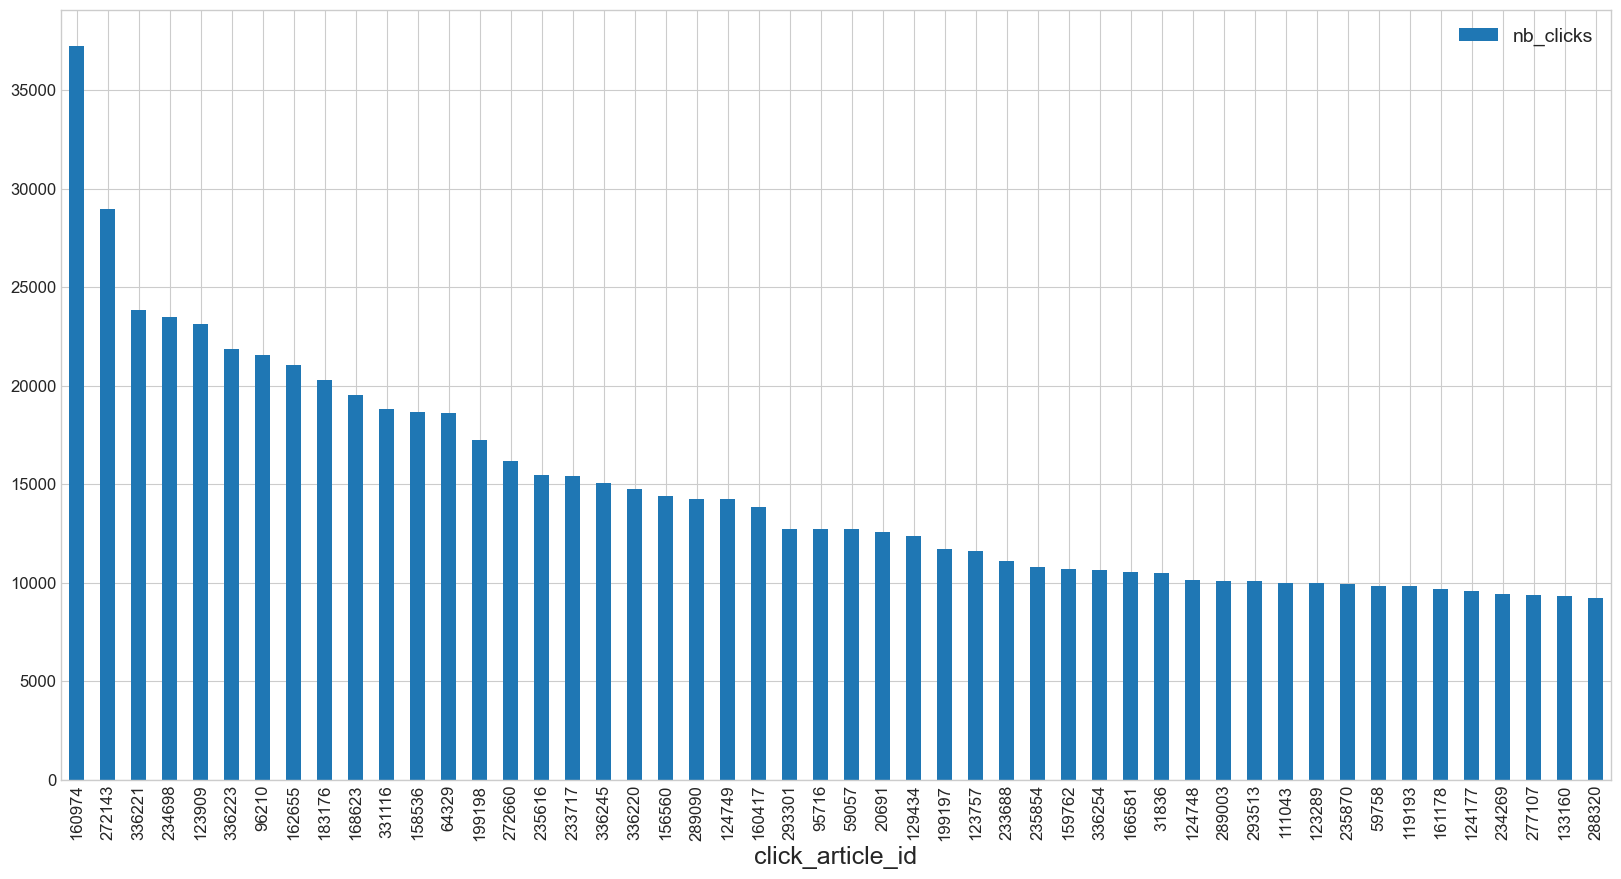

In [39]:
nb_clicks.plot.bar(x='click_article_id', y='nb_clicks', figsize=(20, 10))

Les articles souvent recommandés sont en fait des articles lus par beaucoup d'utilisateurs.